In [2]:
# @title 1. Setup & Download Dataset
# This block installs the Kaggle library and prompts you to upload your kaggle.json key.

import os
from google.colab import files

# Install Kaggle
!pip install -q kaggle

# Check if kaggle.json is already present; if not, ask to upload
if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file now:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully.")

# Download and Unzip the dataset
# We use the 'jonathannield/cctv-action-recognition-dataset' as identified
dataset_name = "jonathannield/cctv-action-recognition-dataset"

if not os.path.exists("cctv_dataset"):
    print(f"Downloading {dataset_name}...")
    !kaggle datasets download -d {dataset_name}

    print("Unzipping dataset...")
    !unzip -q cctv-action-recognition-dataset.zip -d cctv_dataset
    print("Dataset ready in 'cctv_dataset' folder.")
else:
    print("Dataset already exists.")

Please upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 83 bytes
Kaggle API configured successfully.
Dataset URL: https://www.kaggle.com/datasets/jonathannield/cctv-action-recognition-dataset
License(s): unknown
100% 516M/517M [00:01<00:00, 361MB/s]
100% 517M/517M [00:01<00:00, 463MB/s]
Unzipping dataset...
Dataset ready in 'cctv_dataset' folder.


In [3]:
# @title 2. Feature Extraction Pipeline (ResNet50)
# This block extracts features and saves them to a CSV.

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm

# --- CONFIGURATION ---
SAMPLE_RATE = 10       # Extract 1 frame every 10 frames (reduces redundancy)
IMG_SIZE = 224         # ResNet standard input size
BATCH_SIZE = 32        # Batch size for GPU processing
OUTPUT_CSV = "cctv_video_features.csv"

# --- MODEL SETUP ---
print("Loading ResNet50 model...")
# Load pre-trained ResNet50
base_model = models.resnet50(pretrained=True)

# Remove the final classification layer (fc) to get the feature vector (2048 dimensions)
# We create a new model that outputs the layer *before* the classification
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Use everything except the last layer (fc)
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        out = self.features(x)
        return out.view(out.size(0), -1) # Flatten: (Batch, 2048)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeatureExtractor(base_model)
model = model.to(device)
model.eval() # Set to evaluation mode

# Define image transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features_from_video(video_path):
    """
    Reads a video, extracts frames, runs them through ResNet,
    and returns the AVERAGE feature vector for the whole video.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Sampling: Only take every Nth frame
        if frame_count % SAMPLE_RATE == 0:
            # Convert BGR (OpenCV) to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Apply transforms
            frames.append(transform(frame_rgb))

        frame_count += 1
    cap.release()

    if not frames:
        return None

    # Stack frames into a batch tensor
    # Shape: (Num_Frames, 3, 224, 224)
    input_tensor = torch.stack(frames).to(device)

    # Extract features in batches to avoid OOM
    features_list = []
    with torch.no_grad():
        # Process in chunks of BATCH_SIZE
        for i in range(0, len(input_tensor), BATCH_SIZE):
            batch = input_tensor[i : i + BATCH_SIZE]
            features = model(batch) # Output: (Batch_Size, 2048)
            features_list.append(features.cpu().numpy())

    if not features_list:
        return None

    # Concatenate all batches -> Shape: (Total_Frames, 2048)
    all_features = np.concatenate(features_list, axis=0)

    # --- AGGREGATION STRATEGY ---
    # For a CSV, we need a single vector per video.
    # We take the MEAN (Average) of all frame features.
    # This represents the "general content" of the video.
    video_feature_vector = np.mean(all_features, axis=0)

    return video_feature_vector

# --- MAIN EXECUTION LOOP ---

# Find all video files (assuming standard structure: cctv_dataset/train/Class/video.mp4)
# Adjust the glob pattern based on the exact unzip structure
video_files = glob.glob("cctv_dataset/**/*.mp4", recursive=True) + \
              glob.glob("cctv_dataset/**/*.avi", recursive=True) + \
              glob.glob("cctv_dataset/**/*.mpg", recursive=True)

print(f"Found {len(video_files)} video files.")

data_records = []

print("Starting extraction (this may take time)...")
for video_path in tqdm(video_files):
    try:
        # Get label from parent folder name
        label = os.path.basename(os.path.dirname(video_path))
        filename = os.path.basename(video_path)

        # Extract features
        features = extract_features_from_video(video_path)

        if features is not None:
            # Create a dictionary row
            record = {
                "filename": filename,
                "label": label,
                "path": video_path
            }
            # Add features as separate columns (f_0 to f_2047)
            for i, f_val in enumerate(features):
                record[f"f_{i}"] = f_val

            data_records.append(record)

    except Exception as e:
        print(f"Error processing {video_path}: {e}")

# --- EXPORT TO CSV ---
print("Creating DataFrame...")
df = pd.DataFrame(data_records)

print(f"Saving to {OUTPUT_CSV}...")
df.to_csv(OUTPUT_CSV, index=False)

print("Done! You can now download the CSV.")
print(df.head())

Loading ResNet50 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Found 2300 video files.
Starting extraction (this may take time)...


100%|██████████| 2300/2300 [08:11<00:00,  4.68it/s]


Creating DataFrame...
Saving to cctv_video_features.csv...
Done! You can now download the CSV.
                            filename label  \
0  YOUTUBE_YouTubeCCTV228_kick_1.mp4  kick   
1    UCFCRIME_Shooting036_kick_1.mp4  kick   
2  YOUTUBE_YouTubeCCTV238_kick_2.mp4  kick   
3    UCFCRIME_Fighting036_kick_1.mp4  kick   
4     UCFCRIME_Robbery027_kick_2.mp4  kick   

                                                path       f_0       f_1  \
0  cctv_dataset/Videos/Videos/kick/YOUTUBE_YouTub...  0.317026  0.341627   
1  cctv_dataset/Videos/Videos/kick/UCFCRIME_Shoot...  0.218771  0.264430   
2  cctv_dataset/Videos/Videos/kick/YOUTUBE_YouTub...  0.486822  0.398349   
3  cctv_dataset/Videos/Videos/kick/UCFCRIME_Fight...  0.314116  0.355599   
4  cctv_dataset/Videos/Videos/kick/UCFCRIME_Robbe...  0.326117  1.019554   

        f_2       f_3       f_4       f_5       f_6  ...    f_2038    f_2039  \
0  0.246163  0.981658  0.776911  0.075504  0.102929  ...  0.260228  0.470106   
1  1.065298

In [4]:
# @title Sequential Feature Extraction (ResNet50 -> .npy)
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

# --- CONFIGURATION ---
SAMPLE_RATE = 5        # Extract 1 frame every 5 frames (Higher resolution for anomaly detection)
IMG_SIZE = 224
BATCH_SIZE = 32
OUTPUT_DIR = "extracted_features_npy"

# --- MODEL SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ResNet50
base_model = models.resnet50(pretrained=True)
# Remove the classification head (fc layer)
# ResNet50 "avgpool" layer outputs 2048-dim vector
modules = list(base_model.children())[:-1]
feature_extractor = nn.Sequential(*modules).to(device)
feature_extractor.eval()

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_sequential_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % SAMPLE_RATE == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(transform(frame_rgb))

        frame_count += 1
    cap.release()

    if not frames:
        return None

    # Stack into tensor: (Time, 3, 224, 224)
    input_tensor = torch.stack(frames).to(device)

    features_list = []
    with torch.no_grad():
        for i in range(0, len(input_tensor), BATCH_SIZE):
            batch = input_tensor[i : i + BATCH_SIZE]
            # Pass through model
            out = feature_extractor(batch)
            # ResNet output is (Batch, 2048, 1, 1), we flatten to (Batch, 2048)
            out = out.reshape(out.size(0), -1)
            features_list.append(out.cpu().numpy())

    # Concatenate: Result shape is (Total_Frames, 2048)
    return np.concatenate(features_list, axis=0)

# --- MAIN LOOP ---

# Get video files
video_files = glob.glob("cctv_dataset/**/*.mp4", recursive=True) + \
              glob.glob("cctv_dataset/**/*.avi", recursive=True)

print(f"Found {len(video_files)} videos.")

for video_path in tqdm(video_files):
    try:
        # 1. Determine output path
        # If input is: cctv_dataset/train/Fighting/vid001.mp4
        # Output becomes: extracted_features_npy/train/Fighting/vid001.npy

        # Get relative path (e.g., train/Fighting/vid001.mp4)
        rel_path = os.path.relpath(video_path, "cctv_dataset")
        # Remove extension and add .npy
        save_path_base = os.path.splitext(rel_path)[0]
        full_save_path = os.path.join(OUTPUT_DIR, save_path_base + ".npy")

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(full_save_path), exist_ok=True)

        # 2. Extract
        features = extract_sequential_features(video_path)

        # 3. Save
        if features is not None:
            np.save(full_save_path, features)

    except Exception as e:
        print(f"Error on {video_path}: {e}")

print(f"Extraction complete. Features saved in folder: {OUTPUT_DIR}")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 2300 videos.


100%|██████████| 2300/2300 [10:55<00:00,  3.51it/s]

Extraction complete. Features saved in folder: extracted_features_npy


In [5]:
# @title 1. Data Loading & Preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Configuration
MAX_SEQ_LENGTH = 100  # Truncate videos longer than this (to save memory)
FEATURE_DIM = 2048    # ResNet feature size
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Gather Data Paths and Labels
npy_files = glob.glob("extracted_features_npy/**/*.npy", recursive=True)
labels = [os.path.basename(os.path.dirname(p)) for p in npy_files]

# Encode Labels (e.g., Fighting -> 0, Walking -> 1)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
NUM_CLASSES = len(le.classes_)

print(f"Classes found: {le.classes_}")

# Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(npy_files, encoded_labels, test_size=0.2, random_state=42)

# 2. Custom Dataset Class
class VideoFeatureDataset(Dataset):
    def __init__(self, file_paths, labels, max_len=MAX_SEQ_LENGTH):
        self.file_paths = file_paths
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the saved numpy array
        features = np.load(self.file_paths[idx])

        # Truncate if too long
        if features.shape[0] > self.max_len:
            features = features[:self.max_len, :]

        # Convert to tensor
        return torch.FloatTensor(features), torch.tensor(self.labels[idx], dtype=torch.long)

# 3. Collate Function (for Padding)
# Videos have different lengths, so we must pad them to the same length in a batch
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    # Pad sequences with 0
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy

# Create Loaders
train_dataset = VideoFeatureDataset(X_train, y_train)
test_dataset = VideoFeatureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

print("Data loaders ready.")

Classes found: ['fall' 'grab' 'gun' 'hit' 'kick' 'lying_down' 'run' 'sit' 'sneak' 'stand'
 'struggle' 'throw' 'walk']
Data loaders ready.


In [6]:
# @title 2. Base Model Definition & Training

class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.3):
        super(LSTMAnomalyDetector, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)

        # Classification Head
        # We take the output of the last time step
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # out shape: (batch, seq_len, hidden_dim)
        # Decode the hidden state of the last time step
        out = out[:, -1, :]

        out = self.fc(out)
        return out

# Training Function
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_acc': [], 'val_acc': []}

    print(f"Training on {DEVICE}...")

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return history

# --- INITIAL RUN ---
base_model = LSTMAnomalyDetector(input_dim=FEATURE_DIM, hidden_dim=128, num_layers=1, num_classes=NUM_CLASSES).to(DEVICE)
base_history = train_model(base_model, train_loader, test_loader, epochs=15, lr=0.001)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Training on cuda...
Epoch [1/15] | Train Acc: 11.58% | Val Acc: 13.26%
Epoch [2/15] | Train Acc: 12.93% | Val Acc: 14.57%
Epoch [3/15] | Train Acc: 15.38% | Val Acc: 15.22%
Epoch [4/15] | Train Acc: 16.47% | Val Acc: 17.61%
Epoch [5/15] | Train Acc: 16.90% | Val Acc: 16.52%
Epoch [6/15] | Train Acc: 18.32% | Val Acc: 16.74%
Epoch [7/15] | Train Acc: 16.58% | Val Acc: 15.22%
Epoch [8/15] | Train Acc: 17.93% | Val Acc: 15.65%
Epoch [9/15] | Train Acc: 18.70% | Val Acc: 16.30%
Epoch [10/15] | Train Acc: 19.78% | Val Acc: 20.00%
Epoch [11/15] | Train Acc: 21.58% | Val Acc: 17.17%
Epoch [12/15] | Train Acc: 21.14% | Val Acc: 19.35%
Epoch [13/15] | Train Acc: 22.50% | Val Acc: 19.13%
Epoch [14/15] | Train Acc: 21.96% | Val Acc: 20.22%
Epoch [15/15] | Train Acc: 24.29% | Val Acc: 20.22%


Testing on file: UCFCRIME_Burglary040_walk_1.npy
True Action: walk
Model Prediction: struggle


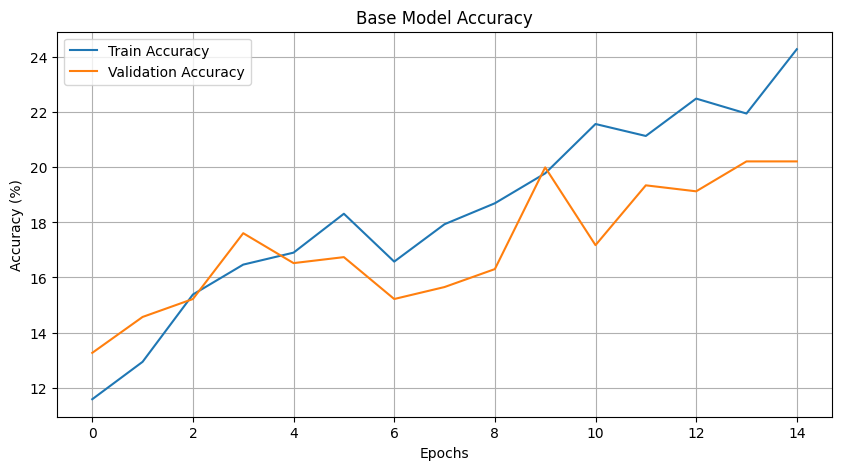

In [7]:
# @title 3. Predict Example & Plot Results

def predict_single_video(model, npy_path, label_encoder):
    model.eval()
    # Load and prep
    features = np.load(npy_path)
    if features.shape[0] > MAX_SEQ_LENGTH:
        features = features[:MAX_SEQ_LENGTH, :]

    tensor_feat = torch.FloatTensor(features).unsqueeze(0).to(DEVICE) # Add batch dim

    with torch.no_grad():
        output = model(tensor_feat)
        _, predicted_idx = torch.max(output, 1)

    pred_label = label_encoder.inverse_transform([predicted_idx.item()])[0]
    return pred_label

# Pick a random test file
import random
random_idx = random.randint(0, len(X_test)-1)
sample_file = X_test[random_idx]
true_label = le.inverse_transform([y_test[random_idx]])[0]

print(f"Testing on file: {os.path.basename(sample_file)}")
prediction = predict_single_video(base_model, sample_file, le)

print(f"True Action: {true_label}")
print(f"Model Prediction: {prediction}")

# Plotting Function
def plot_accuracy(history, title="Model Accuracy"):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(base_history, title="Base Model Accuracy")

In [8]:
# @title 4. Hyperparameter Tuning with Optuna
!pip install -q optuna
import optuna

def objective(trial):
    # 1. Suggest Hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)

    # 2. Build Model with suggested params
    model = LSTMAnomalyDetector(FEATURE_DIM, hidden_dim, num_layers, NUM_CLASSES, dropout).to(DEVICE)

    # 3. Quick Train (fewer epochs for speed)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5): # Train for 5 epochs only to test speed
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

    # 4. Return Validation Accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            out = model(inputs)
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

print("Starting Optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # Run 10 trials

print("Best params:", study.best_params)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.0 MB/s eta 0:00:00


[I 2025-12-18 10:35:34,738] A new study created in memory with name: no-name-ea5872fd-3c9b-48ed-a07f-6000d4d8f4a1


Starting Optimization...


[I 2025-12-18 10:35:41,155] Trial 0 finished with value: 0.1673913043478261 and parameters: {'hidden_dim': 256, 'lr': 0.0004099191795738507, 'num_layers': 2, 'dropout': 0.3272052537200948}. Best is trial 0 with value: 0.1673913043478261.
[I 2025-12-18 10:35:45,600] Trial 1 finished with value: 0.1608695652173913 and parameters: {'hidden_dim': 128, 'lr': 0.0006585959863476846, 'num_layers': 2, 'dropout': 0.41517900072515285}. Best is trial 0 with value: 0.1673913043478261.
[I 2025-12-18 10:35:50,092] Trial 2 finished with value: 0.15434782608695652 and parameters: {'hidden_dim': 128, 'lr': 0.0008797698545543836, 'num_layers': 2, 'dropout': 0.2953210726059151}. Best is trial 0 with value: 0.1673913043478261.
[I 2025-12-18 10:35:54,984] Trial 3 finished with value: 0.12391304347826088 and parameters: {'hidden_dim': 128, 'lr': 0.002971091600188167, 'num_layers': 2, 'dropout': 0.3728046753861437}. Best is trial 0 with value: 0.1673913043478261.
/usr/local/lib/python3.12/dist-packages/torch/

Best params: {'hidden_dim': 256, 'lr': 0.00014783648201033221, 'num_layers': 2, 'dropout': 0.4463753977930256}


Retraining with best parameters: {'hidden_dim': 256, 'lr': 0.00014783648201033221, 'num_layers': 2, 'dropout': 0.4463753977930256}
Training on cuda...
Epoch [1/20] | Train Acc: 11.41% | Val Acc: 11.09%
Epoch [2/20] | Train Acc: 13.10% | Val Acc: 13.70%
Epoch [3/20] | Train Acc: 15.43% | Val Acc: 15.00%
Epoch [4/20] | Train Acc: 15.16% | Val Acc: 14.57%
Epoch [5/20] | Train Acc: 15.87% | Val Acc: 16.52%
Epoch [6/20] | Train Acc: 17.45% | Val Acc: 18.04%
Epoch [7/20] | Train Acc: 18.64% | Val Acc: 17.17%
Epoch [8/20] | Train Acc: 18.59% | Val Acc: 17.17%
Epoch [9/20] | Train Acc: 20.00% | Val Acc: 16.96%
Epoch [10/20] | Train Acc: 19.51% | Val Acc: 19.13%
Epoch [11/20] | Train Acc: 20.00% | Val Acc: 18.26%
Epoch [12/20] | Train Acc: 21.90% | Val Acc: 19.78%
Epoch [13/20] | Train Acc: 21.79% | Val Acc: 18.70%
Epoch [14/20] | Train Acc: 22.17% | Val Acc: 17.83%
Epoch [15/20] | Train Acc: 24.57% | Val Acc: 18.91%
Epoch [16/20] | Train Acc: 25.60% | Val Acc: 21.30%
Epoch [17/20] | Train Acc:

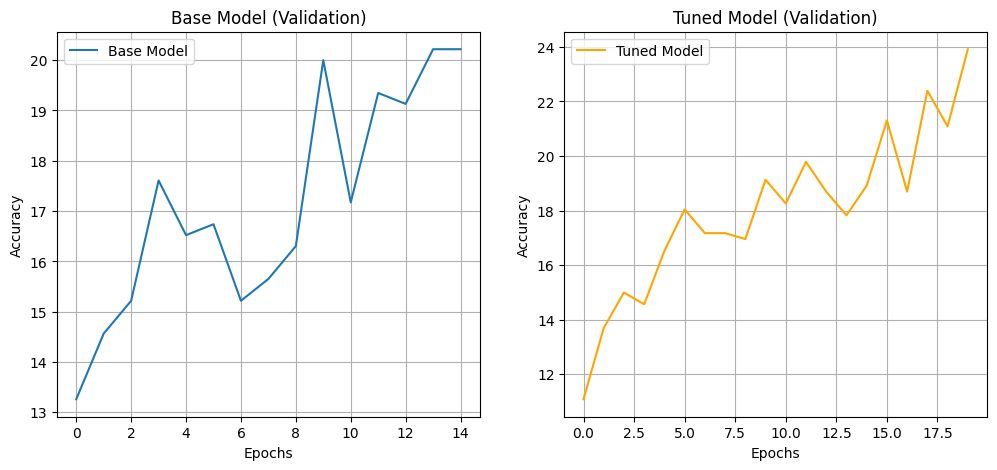

In [9]:
# @title 5. Retrain & Plot Final Accuracy
best_params = study.best_params

print("Retraining with best parameters:", best_params)

# Initialize model with best params
final_model = LSTMAnomalyDetector(
    input_dim=FEATURE_DIM,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    num_classes=NUM_CLASSES,
    dropout=best_params['dropout']
).to(DEVICE)

# Train for longer (20 epochs)
final_history = train_model(final_model, train_loader, test_loader, epochs=20, lr=best_params['lr'])

# Compare Plots
plt.figure(figsize=(12, 5))

# Plot Base
plt.subplot(1, 2, 1)
plt.plot(base_history['val_acc'], label='Base Model')
plt.title("Base Model (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Tuned
plt.subplot(1, 2, 2)
plt.plot(final_history['val_acc'], color='orange', label='Tuned Model')
plt.title("Tuned Model (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output):
        # rnn_output shape: (batch, seq_len, hidden_dim)

        # Calculate attention scores for every time step
        scores = self.attention(rnn_output)       # (batch, seq_len, 1)

        # Softmax ensures weights sum to 1 (probability distribution)
        weights = F.softmax(scores, dim=1)        # (batch, seq_len, 1)

        # Multiply weights by the actual LSTM output to scale important frames up
        # and unimportant frames down.
        # Sum them up to get a single "Context Vector" for the video
        context_vector = torch.sum(weights * rnn_output, dim=1)

        return context_vector, weights

class ImprovedAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(ImprovedAnomalyDetector, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bi-Directional LSTM
        # bidirectional=True doubles the hidden_dim in the output
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Attention Layer
        # Input size is hidden_dim * 2 because of bidirectionality
        self.attention = Attention(hidden_dim * 2)

        # Classification Head
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)

        # LSTM Output shape: (batch, seq_len, hidden_dim * 2)
        lstm_out, _ = self.lstm(x)

        # Apply Attention
        # Context vector summarizes the WHOLE video into one focused vector
        context_vector, attn_weights = self.attention(lstm_out)

        # Classifier
        x = self.fc1(context_vector)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

Training Improved Model on cuda...
Epoch [1/100] | Train Acc: 11.41% | Val Acc: 13.70% | Loss: 2.4519
Epoch [2/100] | Train Acc: 14.13% | Val Acc: 15.43% | Loss: 2.4702
Epoch [3/100] | Train Acc: 13.80% | Val Acc: 16.52% | Loss: 2.4343
Epoch [4/100] | Train Acc: 15.22% | Val Acc: 17.83% | Loss: 2.3823
Epoch [5/100] | Train Acc: 16.68% | Val Acc: 17.61% | Loss: 2.3827
Epoch [6/100] | Train Acc: 18.86% | Val Acc: 18.70% | Loss: 2.3549
Epoch [7/100] | Train Acc: 20.22% | Val Acc: 19.13% | Loss: 2.2906
Epoch [8/100] | Train Acc: 19.02% | Val Acc: 20.00% | Loss: 2.2775
Epoch [9/100] | Train Acc: 21.14% | Val Acc: 19.78% | Loss: 2.2974
Epoch [10/100] | Train Acc: 21.90% | Val Acc: 20.65% | Loss: 2.2295
Epoch [11/100] | Train Acc: 23.86% | Val Acc: 21.30% | Loss: 2.2558
Epoch [12/100] | Train Acc: 24.13% | Val Acc: 22.83% | Loss: 2.2126
Epoch [13/100] | Train Acc: 27.39% | Val Acc: 23.04% | Loss: 2.2207
Epoch [14/100] | Train Acc: 27.55% | Val Acc: 25.22% | Loss: 2.2118
Epoch [15/100] | Train

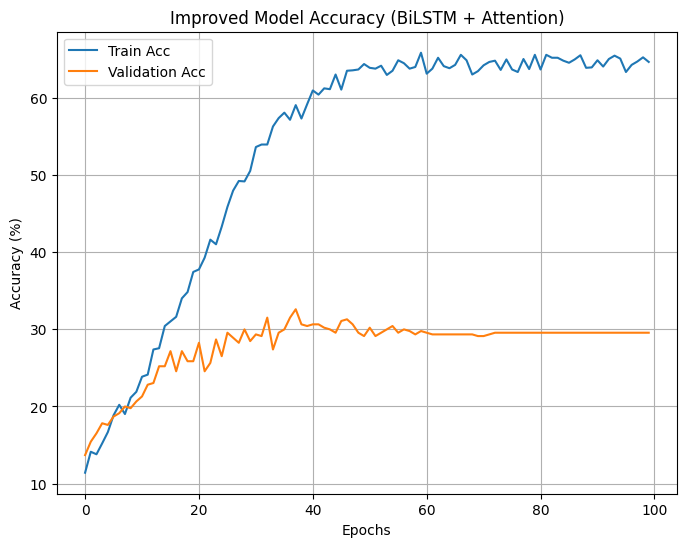

In [13]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_improved_model(model, train_loader, val_loader, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # Added weight_decay for regularization

    # Scheduler: Reduce LR if val_loss doesn't improve for 3 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    history = {'train_acc': [], 'val_acc': [], 'val_loss': []}

    print(f"Training Improved Model on {DEVICE}...")

    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        history['train_acc'].append(train_acc)

        # Validation Phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_running_loss / len(val_loader)

        history['val_acc'].append(val_acc)
        history['val_loss'].append(avg_val_loss)

        # Step the scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Loss: {avg_val_loss:.4f}")

    return history

# --- INSTANTIATE AND TRAIN ---

# Re-initialize the model
improved_model = ImprovedAnomalyDetector(
    input_dim=FEATURE_DIM,
    hidden_dim=256,       # Increased hidden dimension
    num_layers=2,         # 2 Stacked LSTM layers
    num_classes=NUM_CLASSES,
    dropout=0.5           # High dropout to prevent overfitting
).to(DEVICE)

# Train
improved_history = train_improved_model(improved_model, train_loader, test_loader, epochs=100, lr=0.0005)

# --- PLOT COMPARISON ---
plt.figure(figsize=(8, 6))
plt.plot(improved_history['train_acc'], label='Train Acc')
plt.plot(improved_history['val_acc'], label='Validation Acc')
plt.title("Improved Model Accuracy (BiLSTM + Attention)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Dataset 2: UCF-Crime-Small
### Same procedure of model training

In [14]:
# @title 1. Download UCF-Crime (Mini Version)
import os
from google.colab import files

# 1. Setup Kaggle (Upload kaggle.json if needed)
!pip install -q kaggle

if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# 2. Download Dataset
# We use a 'mini' version to save time/space.
dataset_slug = "missan/miniucfcrime"

if not os.path.exists("ucf_crime_dataset"):
    print(f"Downloading {dataset_slug}...")
    !kaggle datasets download -d {dataset_slug}

    print("Unzipping...")
    !unzip -q miniucfcrime.zip -d ucf_crime_dataset
    print("Dataset extracted to 'ucf_crime_dataset'.")
else:
    print("Dataset already exists.")

# Check the folder structure
!ls ucf_crime_dataset

Dataset URL: https://www.kaggle.com/datasets/missan/miniucfcrime
License(s): unknown
 98% 656M/671M [00:11<00:00, 152MB/s]
100% 671M/671M [00:11<00:00, 60.5MB/s]
Unzipping...
Dataset extracted to 'ucf_crime_dataset'.
crimeucfdataset


In [15]:
# @title 2. Sequential Feature Extraction
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import glob
from tqdm import tqdm

# --- CONFIG ---
SAMPLE_RATE = 5      # Extract every 5th frame
IMG_SIZE = 224
BATCH_SIZE = 32
OUTPUT_DIR = "ucf_features_npy"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- MODEL ---
# Load ResNet50 and remove the classification head
base_model = models.resnet50(pretrained=True)
modules = list(base_model.children())[:-1]
feature_extractor = nn.Sequential(*modules).to(DEVICE)
feature_extractor.eval()

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while True:
        ret, frame = cap.read()
        if not ret: break

        if count % SAMPLE_RATE == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(transform(frame))
        count += 1
    cap.release()

    if not frames: return None

    # Batch Process
    input_tensor = torch.stack(frames).to(DEVICE)
    feats = []

    with torch.no_grad():
        for i in range(0, len(input_tensor), BATCH_SIZE):
            batch = input_tensor[i : i + BATCH_SIZE]
            out = feature_extractor(batch)
            out = out.reshape(out.size(0), -1) # Flatten (B, 2048)
            feats.append(out.cpu().numpy())

    return np.concatenate(feats, axis=0)

# --- EXECUTION ---
# Find all videos (UCF usually has subfolders like 'Abuse', 'Arson')
video_files = glob.glob("ucf_crime_dataset/**/*.mp4", recursive=True) + \
              glob.glob("ucf_crime_dataset/**/*.avi", recursive=True)

print(f"Found {len(video_files)} videos.")

for v_path in tqdm(video_files):
    try:
        # Generate Output Path
        rel_path = os.path.relpath(v_path, "ucf_crime_dataset")
        save_path = os.path.join(OUTPUT_DIR, os.path.splitext(rel_path)[0] + ".npy")

        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        if not os.path.exists(save_path): # Skip if done
            features = extract_features(v_path)
            if features is not None:
                np.save(save_path, features)
    except Exception as e:
        print(f"Error {v_path}: {e}")

print("Feature extraction complete.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 33 videos.


100%|██████████| 33/33 [02:25<00:00,  4.41s/it]

Feature extraction complete.


In [16]:
# @title 3. Model Definition (BiLSTM + Attention)
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, rnn_output):
        # rnn_output: (batch, seq_len, hidden_dim)
        scores = self.attention(rnn_output)      # (batch, seq_len, 1)
        weights = F.softmax(scores, dim=1)       # (batch, seq_len, 1)
        # Context: Weighted sum of frames
        context = torch.sum(weights * rnn_output, dim=1)
        return context, weights

class AnomalyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(AnomalyClassifier, self).__init__()

        # Bi-Directional LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Attention (Input size doubles due to bidirectional)
        self.attention = Attention(hidden_dim * 2)

        # Heads
        self.fc1 = nn.Linear(hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, _ = self.attention(lstm_out)
        x = self.fc1(context)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Classes (2): ['Anomaly-Videos-Part-1' 'Normal-Videos-Part-1']
Starting Training...
Epoch 1: Train Acc 50.0% | Val Acc 28.6%
Epoch 2: Train Acc 73.1% | Val Acc 71.4%
Epoch 3: Train Acc 84.6% | Val Acc 71.4%
Epoch 4: Train Acc 88.5% | Val Acc 71.4%
Epoch 5: Train Acc 84.6% | Val Acc 71.4%
Epoch 6: Train Acc 92.3% | Val Acc 42.9%
Epoch 7: Train Acc 96.2% | Val Acc 57.1%
Epoch 8: Train Acc 96.2% | Val Acc 71.4%
Epoch 9: Train Acc 96.2% | Val Acc 71.4%
Epoch 10: Train Acc 100.0% | Val Acc 71.4%
Epoch 11: Train Acc 100.0% | Val Acc 71.4%
Epoch 12: Train Acc 100.0% | Val Acc 71.4%
Epoch 13: Train Acc 100.0% | Val Acc 71.4%
Epoch 14: Train Acc 100.0% | Val Acc 71.4%
Epoch 15: Train Acc 100.0% | Val Acc 71.4%
Epoch 16: Train Acc 100.0% | Val Acc 71.4%
Epoch 17: Train Acc 100.0% | Val Acc 71.4%
Epoch 18: Train Acc 100.0% | Val Acc 71.4%
Epoch 19: Train Acc 100.0% | Val Acc 71.4%
Epoch 20: Train Acc 100.0% | Val Acc 71.4%
Epoch 21: Train Acc 100.0% | Val Acc 71.4%
Epoch 22: Train Acc 100.0% | Val

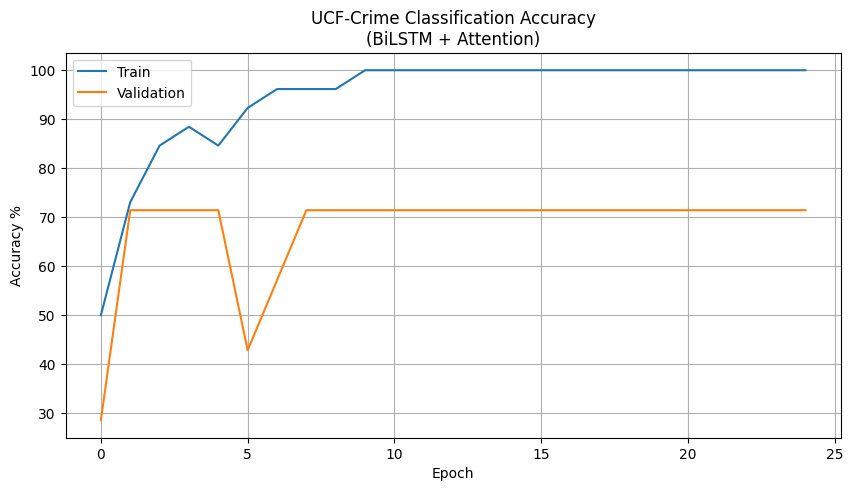

In [18]:
# @title 4. Training Loop & Visualization
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- DATA LOADING ---
npy_files = glob.glob("ucf_features_npy/**/*.npy", recursive=True)
labels_raw = [os.path.basename(os.path.dirname(p)) for p in npy_files]

# Encode Labels (Abuse=0, Arson=1, Normal=2...)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_raw)
NUM_CLASSES = len(le.classes_)
print(f"Classes ({NUM_CLASSES}): {le.classes_}")

X_train, X_test, y_train, y_test = train_test_split(npy_files, encoded_labels, test_size=0.2, stratify=encoded_labels)

class UCFDataset(Dataset):
    def __init__(self, files, labels, max_len=150):
        self.files = files
        self.labels = labels
        self.max_len = max_len
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        feat = np.load(self.files[idx])
        if feat.shape[0] > self.max_len: feat = feat[:self.max_len, :]
        return torch.FloatTensor(feat), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    xx, yy = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy

train_loader = DataLoader(UCFDataset(X_train, y_train), batch_size=16, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(UCFDataset(X_test, y_test), batch_size=16, collate_fn=pad_collate)

# --- TRAINING ---
model = AnomalyClassifier(input_dim=2048, hidden_dim=128, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss()

history = {'train_acc': [], 'val_acc': []}

print("Starting Training...")
EPOCHS = 25
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(out, 1)
        total += y.size(0)
        correct += (pred == y).sum().item()

    train_acc = 100 * correct / total
    history['train_acc'].append(train_acc)

    # Validation
    model.eval()
    v_correct, v_total, v_loss = 0, 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            v_loss += criterion(out, y).item()
            _, pred = torch.max(out, 1)
            v_total += y.size(0)
            v_correct += (pred == y).sum().item()

    val_acc = 100 * v_correct / v_total
    history['val_acc'].append(val_acc)
    scheduler.step(v_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Acc {train_acc:.1f}% | Val Acc {val_acc:.1f}%")

# --- PLOT ---
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title(f"UCF-Crime Classification Accuracy\n(BiLSTM + Attention)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.legend()
plt.grid(True)
plt.show()